In [2]:
! pip install PyWavelets

   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ------------------------------------- -- 3.9/4.2 MB 23.4 MB/s eta 0:00:01
   ---------------------------------------- 4.2/4.2 MB 20.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
! pip install scikit-image

   ---------------------------------------- 0.0/22.7 MB ? eta -:--:--
   - -------------------------------------- 0.8/22.7 MB 5.6 MB/s eta 0:00:04
   ---- ----------------------------------- 2.4/22.7 MB 6.1 MB/s eta 0:00:04
   ------ --------------------------------- 3.9/22.7 MB 6.5 MB/s eta 0:00:03
   ------------ --------------------------- 6.8/22.7 MB 8.6 MB/s eta 0:00:02
   -------------------- ------------------- 11.5/22.7 MB 11.6 MB/s eta 0:00:01
   ----------------------------- ---------- 16.8/22.7 MB 14.1 MB/s eta 0:00:01
   ------------------------------------- -- 21.2/22.7 MB 15.1 MB/s eta 0:00:01
   ---------------------------------------- 22.7/22.7 MB 14.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.optimize import minimize
from skimage import exposure


In [5]:
# Step 1: Define the negative log-likelihood function
def negative_log_likelihood(alpha, n, gamma, S, BTr):
    """
    Computes the negative log-likelihood for given parameters.
    """
    term1 = gamma * (alpha * S + BTr) * (n - 1)
    term2 = -np.log(gamma * (alpha * S + BTr))
    return term1 + term2

In [6]:
# Step 2: Define the sparsity regularization function
def sparsity_term(alpha, wavelet='db2'):
    """
    Computes the L1 norm of wavelet coefficients.
    """
    coeffs = pywt.dwt2(alpha, wavelet=wavelet)
    LL, (LH, HL, HH) = coeffs
    return np.sum(np.abs(LL)) + np.sum(np.abs(LH)) + np.sum(np.abs(HL)) + np.sum(np.abs(HH))


def reconstruct_3d_structure(t, censored, S, BTr, Tp, c, beta, wavelet='db2'):
    """
    Performs 3D reconstruction by solving the optimization problem for Z(x, y).
    """

    def log_likelihood(Z, t, c, Tp, BTr, S, epsilon=1e-10):
        """
        Computes the negative log-likelihood for Z(x, y).
        """
        Z = Z.reshape(t.shape)
        uncensored_indices = ~censored
        t_uncensored = t[uncensored_indices]
        Z_uncensored = Z[uncensored_indices]

        # Avoid invalid values in the logarithm
        delta = t_uncensored - Tp - 2 * Z_uncensored / c
        delta = np.clip(delta, epsilon, None)  # Ensure delta > 0

        term1 = -4 * np.log(delta)
        term2 = -delta / Tp
        return np.sum(term1 + term2)

    def sparsity_term_3d(Z, wavelet):
        coeffs = pywt.dwt2(Z, wavelet=wavelet)
        LL, (LH, HL, HH) = coeffs
        return np.sum(np.abs(LL)) + np.sum(np.abs(LH)) + np.sum(np.abs(HL)) + np.sum(np.abs(HH))

    def objective_function_3d(Z, t, c, Tp, BTr, S, beta):
        likelihood = log_likelihood(Z, t, c, Tp, BTr, S)
        sparsity = beta * sparsity_term_3d(Z.reshape(t.shape), wavelet)
        return (1 - beta) * likelihood + sparsity

    # Initial guess for Z
    Z_init = np.zeros_like(t)
    Z_init[~censored] = c * (t[~censored] - Tp) / 2

    # Constraint: Z(x, y) must be non-negative
    constraints = [{'type': 'ineq', 'fun': lambda Z: Z}]  # Z >= 0

    # Minimize the objective function
    result = minimize(
        objective_function_3d, Z_init.flatten(),
        args=(t, c, Tp, BTr, S, beta),
        constraints=constraints,
        method='SLSQP'
    )

    return result.x.reshape(t.shape)

In [7]:
# Step 3: Define the combined objective function
def objective_function(alpha, n, gamma, S, BTr, beta, wavelet='db2'):
    """
    Combines the negative log-likelihood and sparsity terms.
    """
    alpha = alpha.reshape(n.shape)  # Reshape to match the image dimensions
    nll = np.sum(negative_log_likelihood(alpha, n, gamma, S, BTr))
    sparsity = beta * sparsity_term(alpha, wavelet)
    return (1 - beta) * nll + sparsity

In [8]:
# Step 4: Solve the optimization problem
def estimate_reflectivity(n, gamma, S, BTr, beta, wavelet='db2'):
    """
    Solves the optimization problem to estimate reflectivity.
    """
    # Initialize alpha with a positive value
    alpha_init = np.ones_like(n) * 0.1

    # Constraint: reflectivity must be non-negative
    constraints = [{'type': 'ineq', 'fun': lambda alpha: alpha}]  # alpha >= 0

    # Minimize the objective function
    result = minimize(
        objective_function, alpha_init.flatten(),
        args=(n, gamma, S, BTr, beta, wavelet),
        constraints=constraints,
        method='SLSQP'
    )

    return result.x.reshape(n.shape)


In [9]:
# Step 5: Background Noise Censoring (Step 2)
def background_noise_censoring(t, reflectivity, S, BTr, Tp):
    """
    Censors photons due to background light based on the ROAD statistic and hypothesis test.
    """
    censored = np.zeros_like(t, dtype=bool)
    rows, cols = t.shape

    for x in range(1, rows - 1):
        for y in range(1, cols - 1):
            neighbors = [
                t[x - 1, y - 1], t[x - 1, y], t[x - 1, y + 1],
                t[x, y - 1], t[x, y + 1],
                t[x + 1, y - 1], t[x + 1, y], t[x + 1, y + 1]
            ]
            abs_differences = np.sort(np.abs(np.array(neighbors) - t[x, y]))
            ROAD = np.sum(abs_differences[:4])

            prob_bg = BTr / (reflectivity[x, y] * S + BTr)
            threshold = 4 * Tp * prob_bg

            if ROAD >= threshold:
                censored[x, y] = True

    return censored


In [10]:
# Step 7: Computational Reconstruction of 3D Structure (Step 3)
def reconstruct_3d_structure(t, censored, S, BTr, Tp, c, beta, wavelet='db2'):
    """
    Performs 3D reconstruction by solving the optimization problem for Z(x, y).
    """

    def log_likelihood(Z, t, c, Tp, BTr, S, epsilon=1e-10):
        """
        Computes the negative log-likelihood for Z(x, y).
        """
        Z = Z.reshape(t.shape)
        uncensored_indices = ~censored
        t_uncensored = t[uncensored_indices]
        Z_uncensored = Z[uncensored_indices]

        # Avoid invalid values in the logarithm
        delta = t_uncensored - Tp - 2 * Z_uncensored / c
        delta = np.clip(delta, epsilon, None)  # Ensure delta > 0

        term1 = -4 * np.log(delta)
        term2 = -delta / Tp
        return np.sum(term1 + term2)

    def sparsity_term_3d(Z, wavelet):
        coeffs = pywt.dwt2(Z, wavelet=wavelet)
        LL, (LH, HL, HH) = coeffs
        return np.sum(np.abs(LL)) + np.sum(np.abs(LH)) + np.sum(np.abs(HL)) + np.sum(np.abs(HH))

    def objective_function_3d(Z, t, c, Tp, BTr, S, beta):
        likelihood = log_likelihood(Z, t, c, Tp, BTr, S)
        sparsity = beta * sparsity_term_3d(Z.reshape(t.shape), wavelet)
        return (1 - beta) * likelihood + sparsity

    # Initial guess for Z
    Z_init = np.zeros_like(t)
    Z_init[~censored] = c * (t[~censored] - Tp) / 2

    # Constraint: Z(x, y) must be non-negative
    constraints = [{'type': 'ineq', 'fun': lambda Z: Z}]  # Z >= 0

    # Minimize the objective function
    result = minimize(
        objective_function_3d, Z_init.flatten(),
        args=(t, c, Tp, BTr, S, beta),
        constraints=constraints,
        method='SLSQP'
    )

    return result.x.reshape(t.shape)



In [45]:
# Step 8: Visualization and Parameter Provision
def main():
    # Load and preprocess the reflectivity data
    file_path = 'time_delay_2d_np6.np.npy'
    # data = np.array([np.load(file_path)])
    data = np.load(file_path)

    # Sum photon counts over time
    n = np.sum(data, axis=2)  # Summing over the time axis

    # Define parameters
    gamma = 0.17
    S = 0.09
    BTr = 0.1
    beta = 0.5  # Weighting parameter for sparsity
    Tp = 0.0001  # Pulse duration (example value)
    c = 3e8  # Speed of light in m/s (example value)

    # Step 1: Estimate reflectivity
    reflectivity = estimate_reflectivity(n, gamma, S, BTr, beta)

    # Step 2: Background noise censoring
    # Simulated time-of-arrival data (replace with actual data if available)
    t = np.random.rand(*n.shape)  # Placeholder for time-of-arrival data
    censored = background_noise_censoring(t, reflectivity, S, BTr, Tp)

    # Step 3: Reconstruct 3D structure
    Z = reconstruct_3d_structure(t, censored, S, BTr, Tp, c, beta)

    # Normalize the reflectivity and 3D data for visualization
    reflectivity_normalized = exposure.rescale_intensity(reflectivity, out_range=(0, 1))
    Z_normalized = exposure.rescale_intensity(Z, out_range=(0, 1))

    # Visualize Reflectivity
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    # plt.imshow(np.array([reflectivity_normalized[0]] * 10), cmap='gray', interpolation='nearest')
    plt.imshow(reflectivity_normalized, cmap='gray', interpolation='nearest')
    plt.colorbar(label="Normalized Reflectivity")
    plt.title("Reflectivity Reconstruction")
    plt.axis('off')

    # Visualize 3D Structure
    plt.subplot(1, 3, 2)
    # plt.imshow(np.array([Z_normalized[0]] * 10), cmap='viridis', interpolation='nearest')
    plt.imshow(Z_normalized, cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Normalized Depth")
    plt.title("3D Structure Reconstruction")
    plt.axis('off')

    # Combined Visualization
    plt.subplot(1, 3, 3)
    combined = reflectivity_normalized * 0.5 + Z_normalized * 0.5
    # plt.imshow(np.array([combined[0]] * 10), cmap='plasma', interpolation='nearest')
    plt.imshow(combined, cmap='plasma', interpolation='nearest')
    plt.colorbar(label="Combined Visualization")
    plt.title("Combined Reflectivity & Depth")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return reflectivity_normalized, Z_normalized, combined, censored

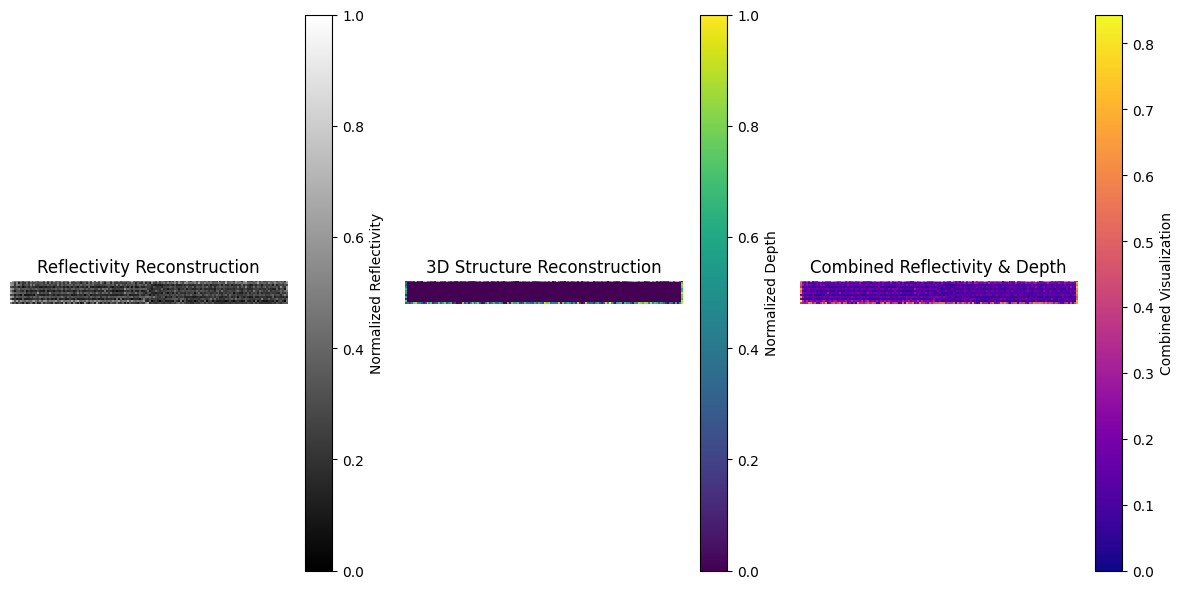

In [46]:
if __name__ == "__main__":
    reflectivity_normalized, Z_normalized, combined, censored = main()


In [50]:
for i in range(1, Z_normalized.shape[0], 2): #reverse every other row because of the scanning procedure we followed
    Z_normalized[i] = Z_normalized[i][::-1]
    reflectivity_normalized[i] = reflectivity_normalized[i][::-1]
    combined[i] = combined[i][::-1]

(-0.5, 141.5, 11.5, -0.5)

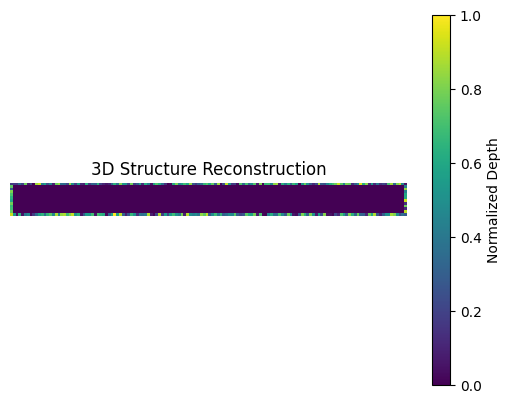

In [51]:
plt.imshow(Z_normalized, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Normalized Depth")
plt.title("3D Structure Reconstruction")
plt.axis('off')

C:\Users\namra\AppData\Local\Temp\ipykernel_32032\1993702347.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(censored), cmap='viridis', interpolation='nearest')


(-0.5, 141.5, 11.5, -0.5)

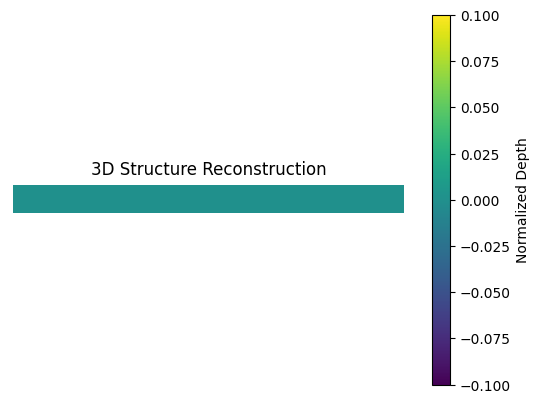

In [64]:
plt.imshow(np.log(censored), cmap='viridis', interpolation='nearest')
plt.colorbar(label="Normalized Depth")
plt.title("3D Structure Reconstruction")
plt.axis('off')

C:\Users\namra\AppData\Local\Temp\ipykernel_32032\3714283198.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(reflectivity_normalized), cmap='gray', interpolation='nearest')


(-0.5, 141.5, 11.5, -0.5)

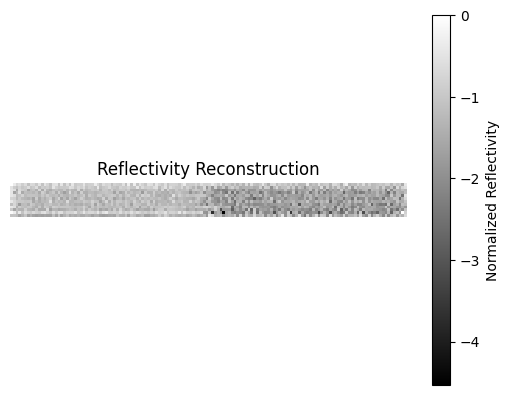

In [61]:
plt.imshow(np.log(reflectivity_normalized), cmap='gray', interpolation='nearest')
plt.colorbar(label="Normalized Reflectivity")
plt.title("Reflectivity Reconstruction")
plt.axis('off')

(-0.5, 141.5, 11.5, -0.5)

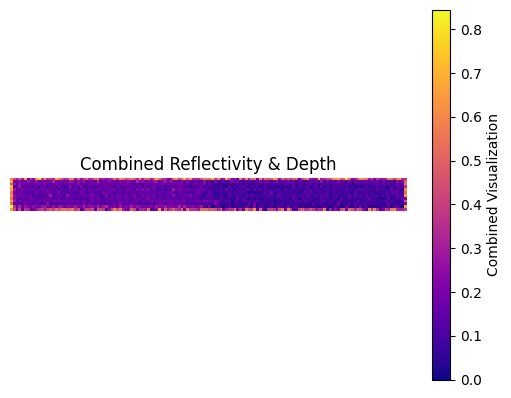

In [62]:
plt.imshow(combined, cmap='plasma', interpolation='nearest')
plt.colorbar(label="Combined Visualization")
plt.title("Combined Reflectivity & Depth")
plt.axis('off')